# **UAS KOMPUTASI KUANTUM**
* # **NAMA: TIMOTHY MULYA CAHYANA**

* # **NIM: A11.2021.13887**



In [1]:
!pip install qiskit==0.46.1 qiskit-aer pylatexenc qiskit_machine_learning==0.7.2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 11.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 2.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 97.8/97.8 kB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.2/6.2 MB 27.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 308.6/308.6 kB 18.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.4/133.4 kB 8.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 30.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 kB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.7/49.7 kB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.4/39.4 MB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, explained_variance_score, median_absolute_error

from IPython.display import clear_output

from qiskit import Aer
from qiskit.utils import algorithm_globals
from qiskit.circuit import QuantumCircuit, ParameterVector
from qiskit.opflow import PauliSumOp
from qiskit.primitives import Estimator
from qiskit_machine_learning.neural_networks import EstimatorQNN
from qiskit_machine_learning.algorithms import NeuralNetworkRegressor
from qiskit.algorithms.optimizers import COBYLA

<ipython-input-2-6cb67ce3d939>:16: DeprecationWarning: The ``qiskit.opflow`` module is deprecated as of qiskit-terra 0.24.0. It will be removed in Qiskit 1.0. For code migration guidelines, visit https://qisk.it/opflow_migration.
  from qiskit.opflow import PauliSumOp
<ipython-input-2-6cb67ce3d939>:20: DeprecationWarning: ``qiskit.algorithms`` has been migrated to an independent package: https://github.com/qiskit-community/qiskit-algorithms. The ``qiskit.algorithms`` import path is deprecated as of qiskit-terra 0.25.0 and will be removed in Qiskit 1.0. Please run ``pip install qiskit_algorithms`` and use ``import qiskit_algorithms`` instead.
  from qiskit.algorithms.optimizers import COBYLA


# **1. Load Dataset (N-Heterocyclic)**

In [3]:
from google.colab import drive
# Mount Google Drive
drive.mount('/content/drive')

# Read the data
data = pd.read_csv('/content/drive/MyDrive/Research/N-Heterocyclic.csv')

Mounted at /content/drive


In [4]:
# Replace whitespaces in feature names with underscores
data.columns = data.columns.str.replace(' ', '_')

# Separate features and target
X = data.drop('IE_(%)', axis=1)  # Features
y = data['IE_(%)']  # Target

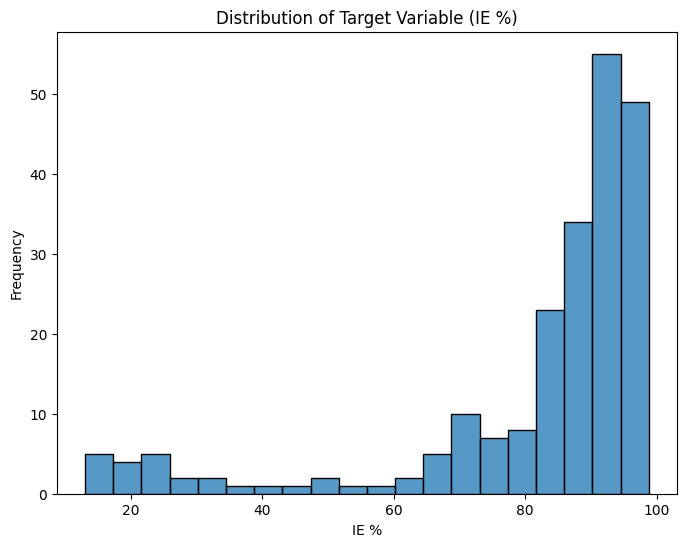

In [5]:
# Visualize the distribution of the target variable
plt.figure(figsize=(8, 6))
sns.histplot(y, kde=False)
plt.title('Distribution of Target Variable (IE %)')
plt.xlabel('IE %')
plt.ylabel('Frequency')
plt.show()

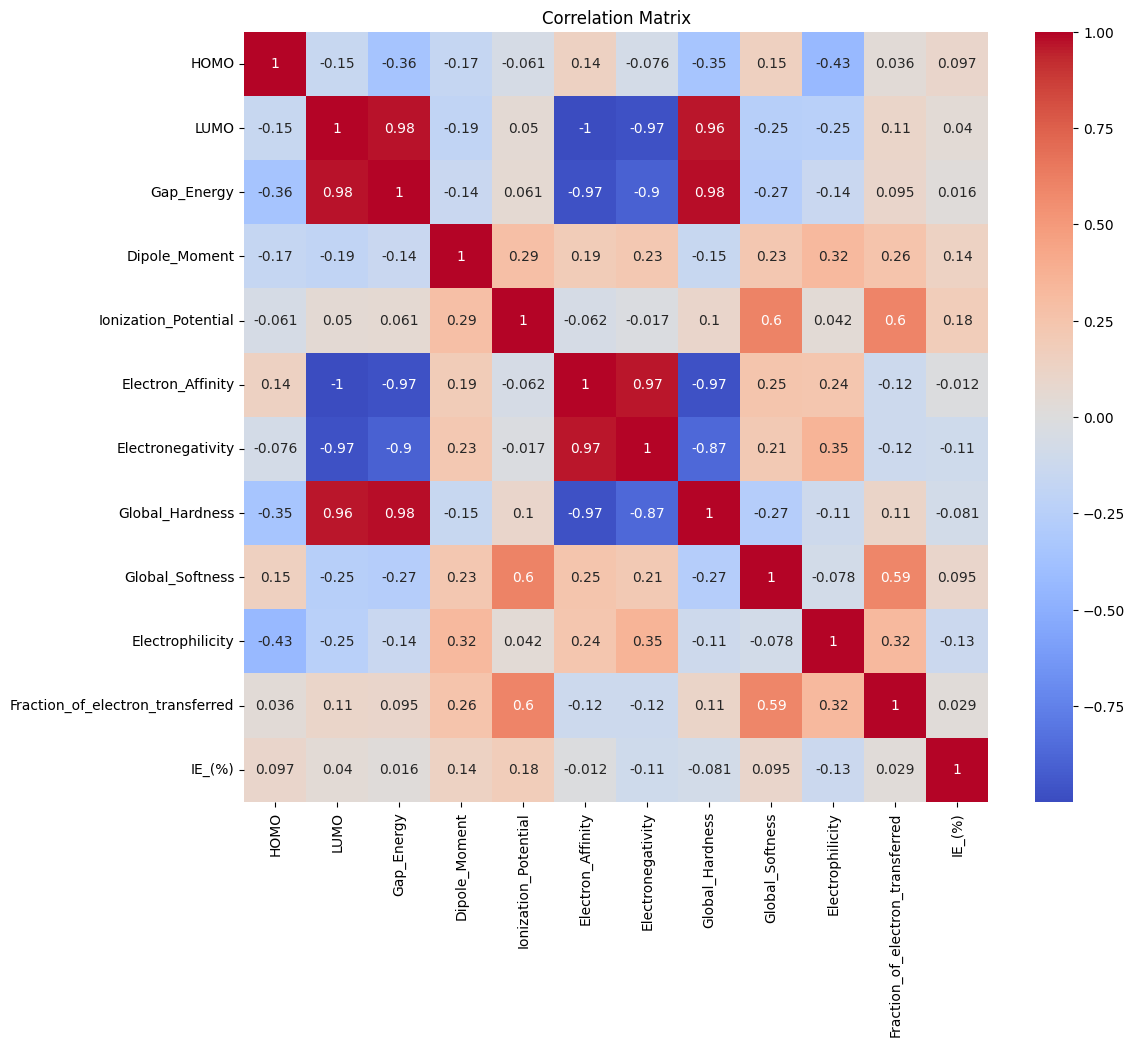

In [6]:
# Correlation matrix
plt.figure(figsize=(12, 10))
correlation_matrix = data.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

# **2. Pre-processing**

In [7]:
# Apply Min-Max Scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Objective function values list
objective_func_vals = []
def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

# **3. Estimator QNN Model**

<ipython-input-8-6034e9926261>:3: DeprecationWarning: The 'qiskit.Aer' entry point is deprecated and will be removed in Qiskit 1.0. You should use 'qiskit_aer.Aer' directly instead.
  simulator = Aer.get_backend('qasm_simulator')


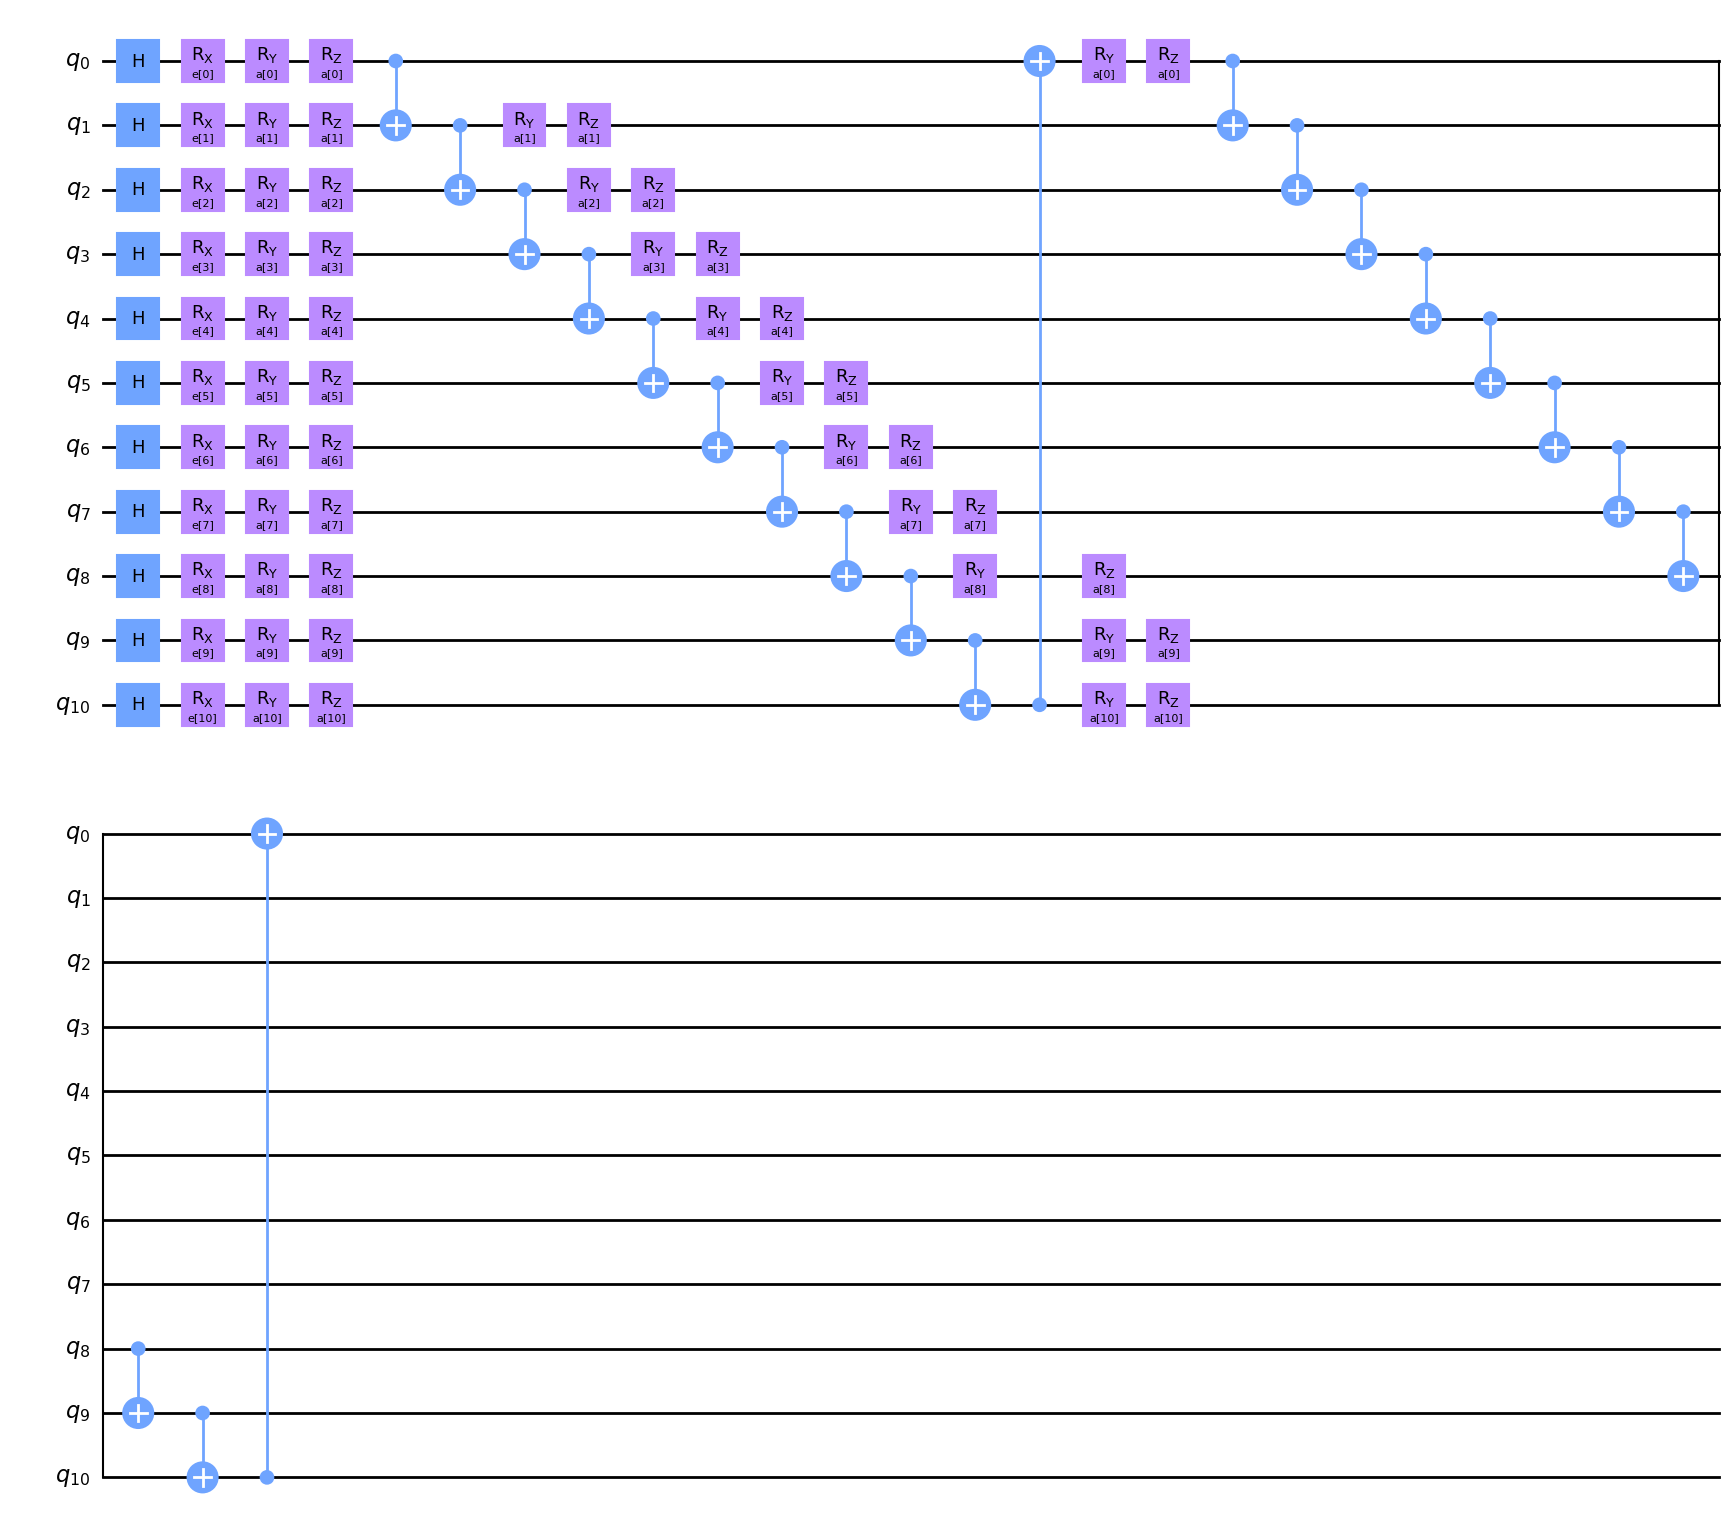

In [8]:
# Parameters
num_qubits = X.shape[1]
simulator = Aer.get_backend('qasm_simulator')
optimizer = COBYLA(maxiter=100)  # Can be optimized
param_encoding = ParameterVector('e', num_qubits)
param_ansatz = ParameterVector('a', num_qubits)
observable = PauliSumOp.from_list([("Z" * num_qubits, 1.0)])  # Updated for regression

qc = QuantumCircuit(num_qubits)

# Apply Hadamard gates to all qubits to create a superposition
for i in range(num_qubits):
    qc.h(i)

# Data Encoding with RX rotations (assuming numerical data is normalized)
for i in range(num_qubits):
    qc.rx(param_encoding[i], i)

# Ansatz layer 1
for i in range(num_qubits):
    qc.ry(param_ansatz[i], i)
for i in range(num_qubits):
    qc.rz(param_ansatz[i], i)

# Entangling layer 1
for i in range(num_qubits - 1):
    qc.cx(i, i + 1)
qc.cx(num_qubits - 1, 0)  # wrap around

# Ansatz layer 2 (if needed, you can add more layers similarly)
for i in range(num_qubits):
    qc.ry(param_ansatz[i], i)
for i in range(num_qubits):
    qc.rz(param_ansatz[i], i)

# Entangling layer 2 (if needed, you can add more layers similarly)
for i in range(num_qubits - 1):
    qc.cx(i, i + 1)
qc.cx(num_qubits - 1, 0)  # wrap around

# QNN regressor
estimator = Estimator()
qnn = EstimatorQNN(
    circuit=qc,
    estimator=estimator,
    observables=observable,
    input_params=param_encoding,
    weight_params=param_ansatz,
)

regressor = NeuralNetworkRegressor(
    neural_network=qnn, optimizer=optimizer, callback=callback_graph
)

# Plot circuit
qc.draw(output='mpl', style="clifford")

# **4. K-Fold Cross-Validation**

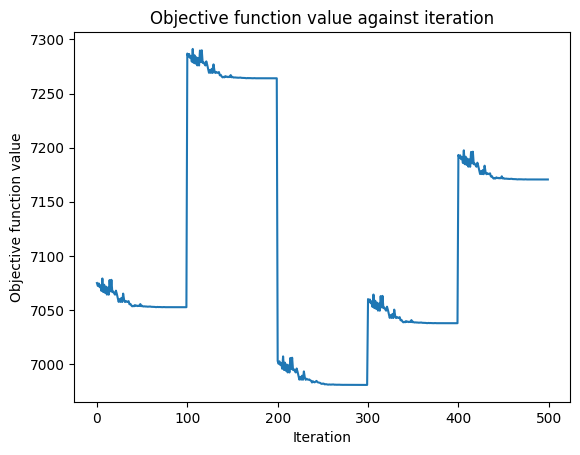

In [9]:
kf = KFold(n_splits=5, shuffle=True, random_state=algorithm_globals.random_seed)

metrics = {
    'mse': [],
    'rmse': [],
    'mae': [],
    'r2': [],
    'evs': [],
    'median_ae': []
}

for train_index, test_index in kf.split(X_scaled):
    X_train, X_test = X_scaled[train_index], X_scaled[test_index]
    y_train, y_test = y[train_index], y[test_index]

    regressor.fit(X_train, y_train)

    y_pred_tr = regressor.predict(X_train)
    y_pred_ts = regressor.predict(X_test)

    mse_tr = mean_squared_error(y_train, y_pred_tr)
    rmse_tr = np.sqrt(mse_tr)
    mae_tr = mean_absolute_error(y_train, y_pred_tr)
    r2_tr = r2_score(y_train, y_pred_tr)
    evs_tr = explained_variance_score(y_train, y_pred_tr)
    median_ae_tr = median_absolute_error(y_train, y_pred_tr)

    mse_ts = mean_squared_error(y_test, y_pred_ts)
    rmse_ts = np.sqrt(mse_ts)
    mae_ts = mean_absolute_error(y_test, y_pred_ts)
    r2_ts = r2_score(y_test, y_pred_ts)
    evs_ts = explained_variance_score(y_test, y_pred_ts)
    median_ae_ts = median_absolute_error(y_test, y_pred_ts)

    metrics['mse'].append((mse_tr, mse_ts))
    metrics['rmse'].append((rmse_tr, rmse_ts))
    metrics['mae'].append((mae_tr, mae_ts))
    metrics['r2'].append((r2_tr, r2_ts))
    metrics['evs'].append((evs_tr, evs_ts))
    metrics['median_ae'].append((median_ae_tr, median_ae_ts))


# **5. Model Evaluation and Visualizations**

In [10]:
def print_avg_metrics(metrics, dataset_name):
    """Print average metrics for train and test datasets."""
    print(f'{dataset_name} Set Average Metrics:')
    for metric, values in metrics.items():
        train_vals, test_vals = zip(*values)
        avg_train = np.mean(train_vals)
        avg_test = np.mean(test_vals)
        print(f'{metric.upper()}: Train Avg = {avg_train}, Test Avg = {avg_test}')
    print('')

print_avg_metrics(metrics, 'TRAIN/TEST')

TRAIN/TEST Set Average Metrics:
MSE: Train Avg = 7101.151442622262, Test Avg = 7101.046781516721
RMSE: Train Avg = 84.26615545902528, Test Avg = 84.2327183351779
MAE: Train Avg = 81.60819651918396, Test Avg = 81.60596645811965
R2: Train Avg = -15.328271064963806, Test Avg = -18.92591857326417
EVS: Train Avg = -4.4408920985006264e-17, Test Avg = -4.4408920985006264e-17
MEDIAN_AE: Train Avg = 89.87704151097378, Test Avg = 89.80904151097378



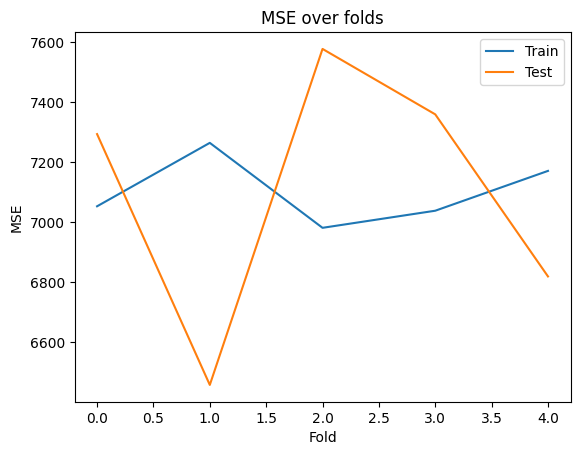

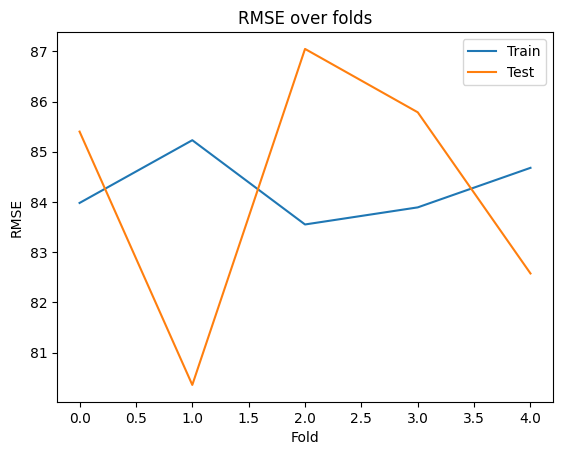

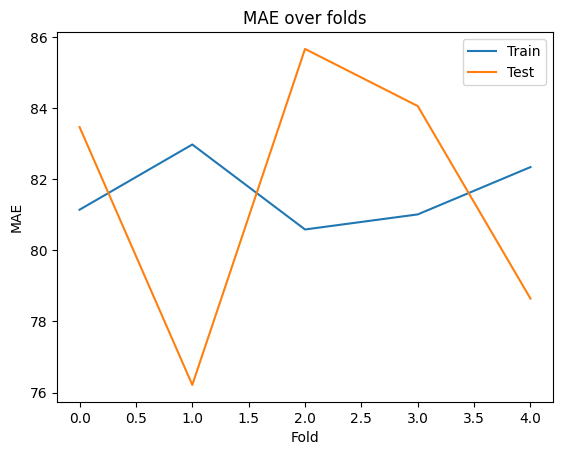

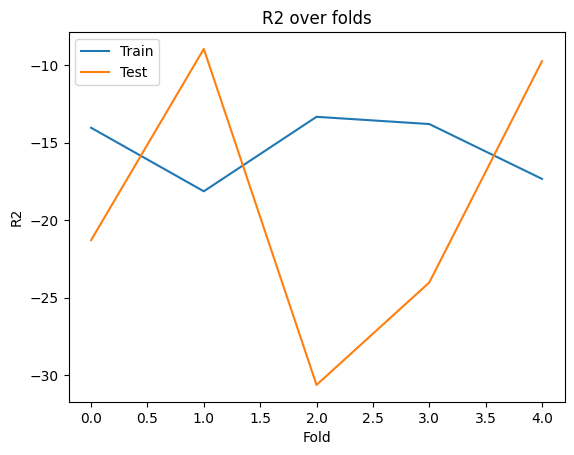

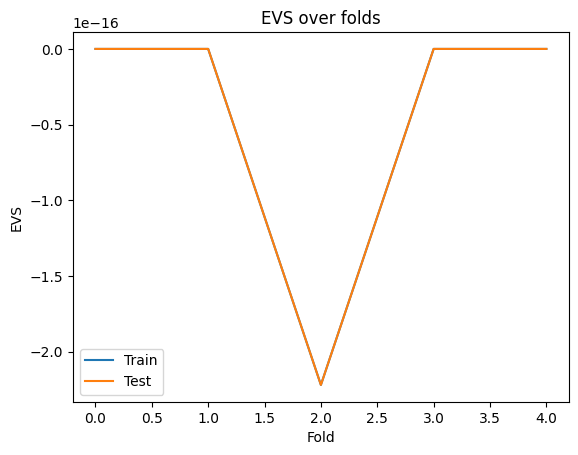

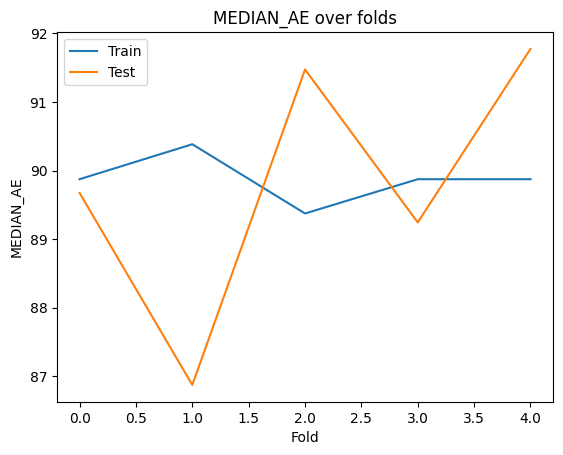

In [11]:
# Plot metrics over folds
for metric, values in metrics.items():
    train_vals, test_vals = zip(*values)
    plt.figure()
    plt.plot(train_vals, label='Train')
    plt.plot(test_vals, label='Test')
    plt.title(f'{metric.upper()} over folds')
    plt.xlabel('Fold')
    plt.ylabel(metric.upper())
    plt.legend()
    plt.show()

In [ ]:
# Train the final model on the entire dataset
regressor.fit(X_scaled, y)
y_pred = regressor.predict(X_scaled)

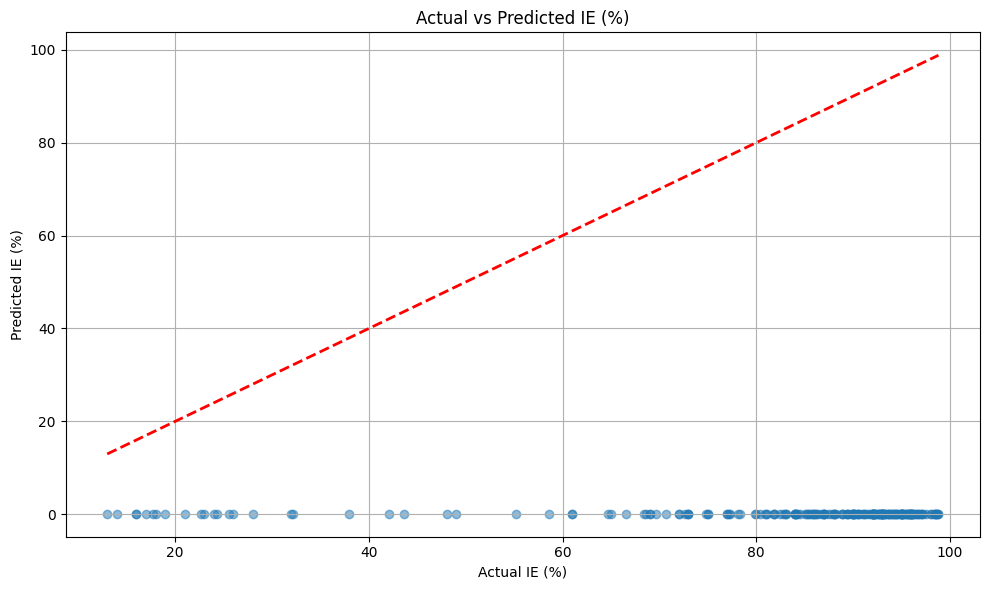

In [13]:
# Create scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(y, y_pred, alpha=0.5)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', lw=2)
plt.xlabel('Actual IE (%)')
plt.ylabel('Predicted IE (%)')
plt.title('Actual vs Predicted IE (%)')
plt.grid(True)
plt.tight_layout()
plt.show()